![](HW.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
class BernoulliBandit:
    def __init__(self, p1, p2):
        self.probs = np.array([p1,p2])  
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx] 
        self.M = 2 # the number of arms

    def step(self, k):
        #return the rewards
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0
# p1, p2 = 0.9, 0.6
# bandit_arm = BernoulliBandit(p1, p2)
# print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
#       (bandit_arm.best_idx+1, bandit_arm.best_prob))

In [3]:
class Solver:
    """ BASIC FRAMEWORK OF MAB """
    def __init__(self, bandit,num_steps): # bandit: class BernoulliBandit
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.M)  # 每根拉杆的尝试次数
        self.num_steps = num_steps  # 总运行次数
        self.regret = 0.  # 当前步的累积懊悔
        self.actions = []  # 维护一个列表,记录每一步的动作
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔
        self.optimal_percentages = []  # 维护一个列表,记录每一步的选择概率

    def update_regret(self, k):
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k] #delta^*-delta_i = p1 -p2
        self.regrets.append(self.regret)
    

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self):
        # 运行一定次数,num_steps为总运行次数
        for i in range(self.num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)
            if i!=0:
               self.optimal_percentages.append(self.counts[self.bandit.best_idx]/(i+1))


In [4]:
def plot_results(data, percentage, i,prob):
    # for solver in solvers:
    #     time_list = range(len(solver.regrets))
    #     plt.plot(time_list, solver.regrets, label='p1={},p2={}'.format(prob[0],prob[1]))
    palette = pyplot.get_cmap('Set1')
    color=palette(i)
    _,axs=plt.subplots(1,2,figsize=(12,6),sharex=True,sharey=False)
    plt.figure(figsize=(16,8), dpi=80)
    plt.figure(1)
    # print(np.shape(data))
    _, p = np.shape(data)
    iters = range(1,p+1)
    avg=np.mean(data,axis=0)
    std=np.std(data,axis=0)
    r1 = list(map(lambda x: x[0]-x[1], zip(avg, std)))
    r2 = list(map(lambda x: x[0]+x[1], zip(avg, std)))

    axs[0].plot(iters, avg, color=color,label='p1={},p2={}'.format(prob[0],prob[1]),linewidth=3.5)
    axs[0].set_xlabel('Time steps')
    axs[0].set_ylabel('Cumulative regrets')
    axs[0].fill_between(iters, r1, r2, color=color, alpha=0.2)
    
    iters = range(2,p+1)
    avg=np.mean(percentage,axis=0)
    std=np.std(percentage,axis=0)
    r1 = list(map(lambda x: x[0]-x[1], zip(avg, std)))
    r2 = list(map(lambda x: x[0]+x[1], zip(avg, std)))
    # ax2 = plt.subplot(122)
    axs[1].plot(iters, avg, color=color,label='p1={},p2={}'.format(prob[0],prob[1]),linewidth=3.5)
    axs[1].fill_between(iters, r1, r2, color=color, alpha=0.2)
    axs[1].set_xlabel('Time steps')
    axs[1].set_ylabel('percentage of optimal arm played')

    # ax2.plot(iters, avg, color=color,label='p1={},p2={}'.format(prob[0],prob[1]),linewidth=3.5)
    # ax2.fill_between(iters, r1, r2, color=color, alpha=0.2)
    # ax2.xlabel('Time steps')
    # ax2.ylabel('percentage of optimal arm played')
    # ax2.title('%d-armed bandit_P%d' % (2,i))
    # ax2.legend()


    plt.show()

<Figure size 1280x640 with 0 Axes>

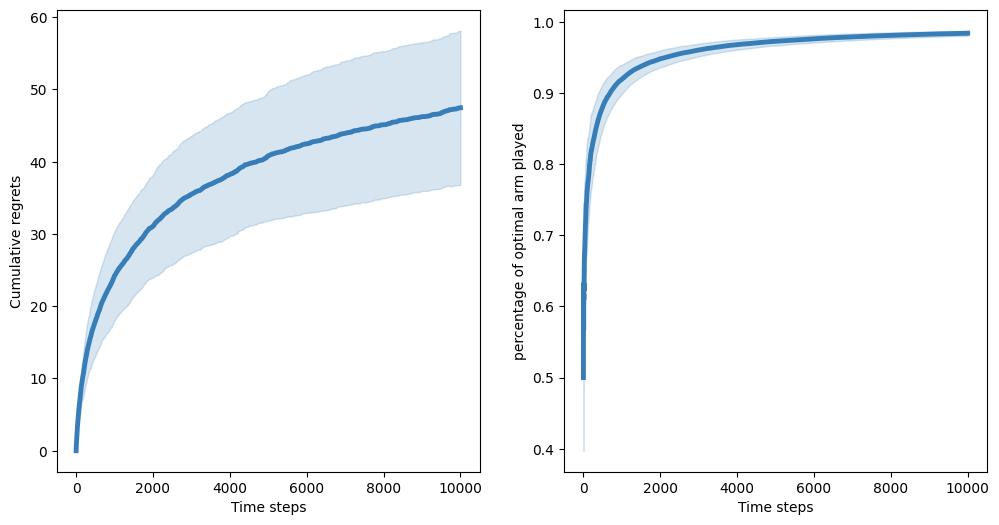

<Figure size 1280x640 with 0 Axes>

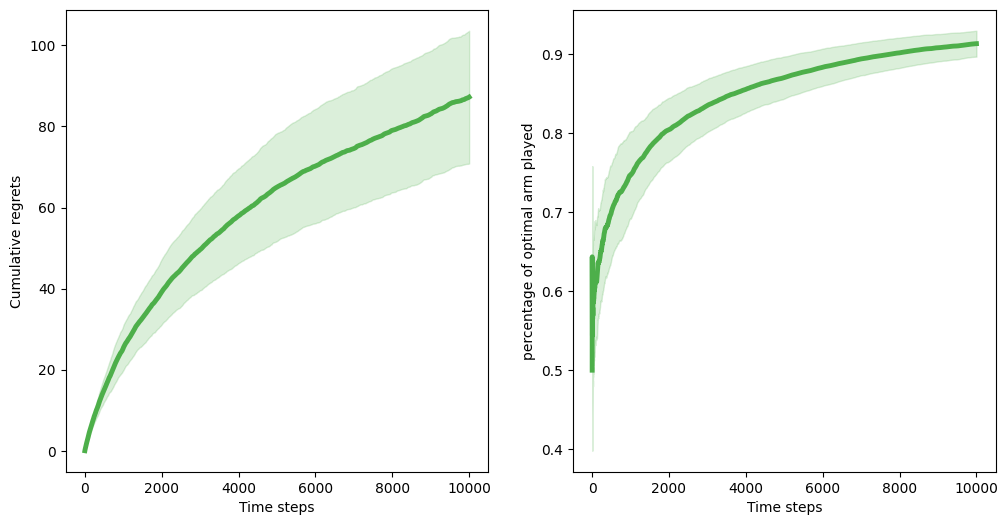

<Figure size 1280x640 with 0 Axes>

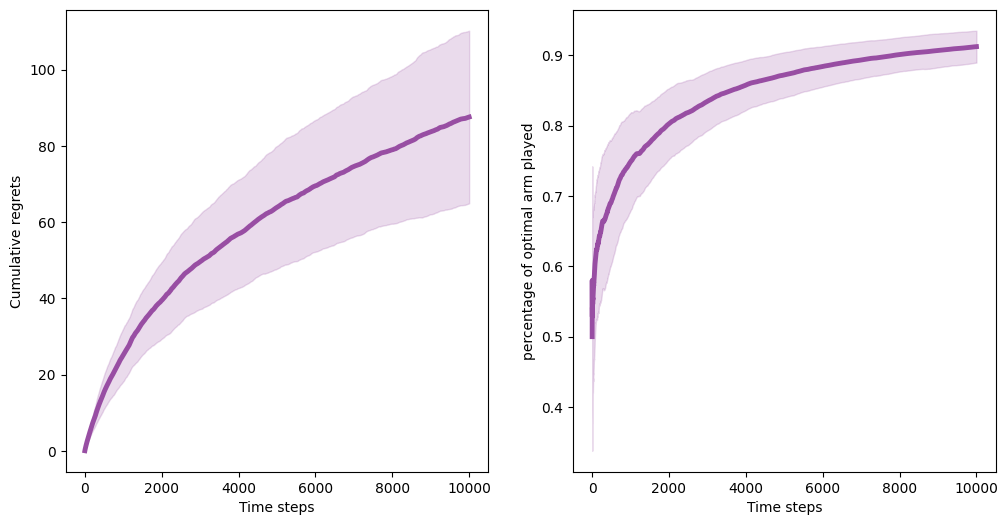

In [6]:
class UCB(Solver):
    """ UCB算法,继承Solver类 """
    def __init__(self, bandit,num_steps):
        super(UCB, self).__init__(bandit,num_steps)
        self.total_count = 0
        # self.estimates = np.array([.0] * self.bandit.M)
        self.estimates = np.array([0.] * self.bandit.M)


    def run_one_step(self):
        self.total_count += 1
        if self.counts.all()==0:
            k = np.where(self.counts==0)[0][0]
            r = self.bandit.step(k)
            self.estimates[k] = r
        else:
            ucb = self.estimates +  np.sqrt(
                2* np.log(self.total_count) / self.counts)  # 计算上置信界
            k = np.argmax(ucb)  # 选出上置信界最大的拉杆
            r = self.bandit.step(k)
            self.estimates[k] += 1. / (self.counts[k] + 1) * (r -
                                                            self.estimates[k])
        return k

probs = np.array([[0.9,0.6],[0.9,0.8],[0.55,0.45]])
for i, prob in enumerate(probs):
    p1, p2 = prob
    bandit_arm = BernoulliBandit(p1, p2)
    data = []
    percentage = []
    for epoch in range(100):
        UCB_solver = UCB(bandit_arm, 10000)
        UCB_solver.run()
        data.append(UCB_solver.regrets)
        percentage.append(UCB_solver.optimal_percentages)
        
    data = np.array(data)
    percentage = np.array(percentage)
    plot_results(data,percentage,i+1, prob)



<Figure size 1280x640 with 0 Axes>

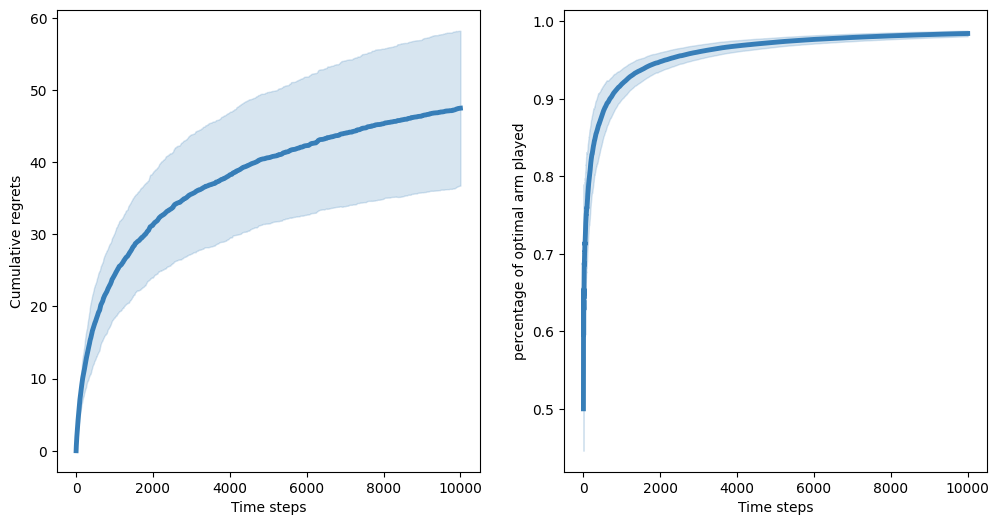

<Figure size 1280x640 with 0 Axes>

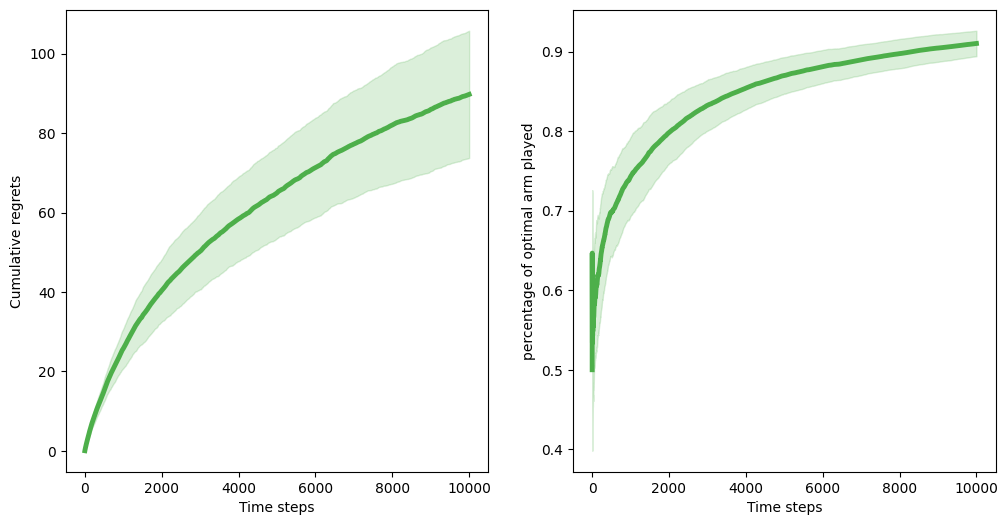

<Figure size 1280x640 with 0 Axes>

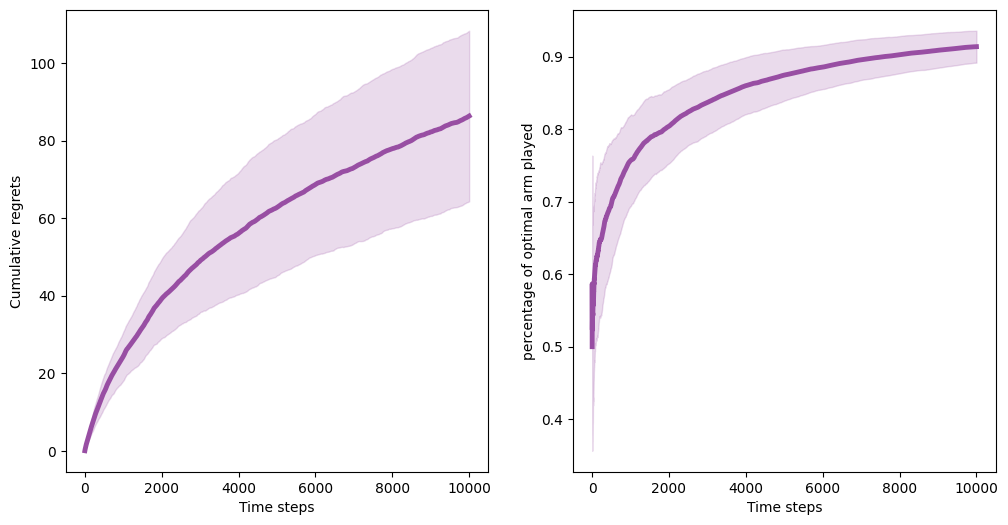

In [37]:
class V_UCB(Solver):
    def __init__(self, bandit,num_steps):
        super(UCB, self).__init__(bandit,num_steps)
        self.total_count = 0
        # self.estimates = np.array([.0] * self.bandit.M)
        self.estimates = np.array([0.] * self.bandit.M)


    def run_one_step(self):
        self.total_count += 1
        if self.counts.all()==0:
            k = np.where(self.counts==0)[0][0]
            r = self.bandit.step(k)
            self.estimates[k] = r
        else:
            ucb = self.estimates +  np.sqrt(
                2* np.log(self.num_steps) / self.counts)  # 计算上置信界
            k = np.argmax(ucb)  # 选出上置信界最大的拉杆
            r = self.bandit.step(k)
            self.estimates[k] += 1. / (self.counts[k] + 1) * (r -
                                                            self.estimates[k])
        return k

# 


probs = np.array([[0.9,0.6],[0.9,0.8],[0.55,0.45]])
for i, prob in enumerate(probs):
    p1, p2 = prob
    bandit_arm = BernoulliBandit(p1, p2)
    data = []
    percentage = []
    for epoch in range(100):
        UCB_solver = UCB(bandit_arm, 10000)
        UCB_solver.run()
        data.append(UCB_solver.regrets)
        percentage.append(UCB_solver.optimal_percentages)
        
    data = np.array(data)
    percentage = np.array(percentage)
    plot_results(data,percentage,i+1, prob)
